<a target="_blank" href="https://colab.research.google.com/github/go-bgc/2023-workshop-python/blob/main/BGC_region_float_data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="argopy logo" width="200"/> 

# Download and visualise BGC data over an ocean region

- If using colab, click ![open in colab](img/2023-08-18-14-30-43.png) above.
- Once open, click on ![copy to drive](img/2023-08-18-14-49-16.png) to make your own version of the notebook.

#### This notebook is adapted from a notebook written by Guillaume Maze, lead developer of [argopy](https://argopy.readthedocs.io/).

This notebook shows how to:
- download BGC-Argo data for a space/time domain
- plot a map with floats trajectory
- plot BGC data

### setting up environment
The default colab environment includes almost everything needed. We can pip-install a few more packages
*note - the specific argopy version below is needed for bgc support*

In [1]:
!pip install argopy==0.1.14rc2
!pip install colab-xterm
!pip install cmocean
!pip install cartopy
!pip install matplotlib

  Obtaining dependency information for colab-xterm from https://files.pythonhosted.org/packages/b5/c9/b401fb2a3ab8479a4c3c3ad3f381e9a086dcfdd7a5d6c5190ab80ffb8f8b/colab_xterm-0.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 2.9 MB/s eta 0:00:00


## Import and setup

In [1]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with useful pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
xr.set_options(display_expand_attrs = False)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

## Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [3]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
#BOX = [40, 110, 0, 30, 600, 700, '2022-01', '2023-08']
BOX = [-100, -70, -25, 5, 0,1000, '2022-08', '2023-08']

## Get more info about this region using the ArgoIndex

In [4]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (289306 records)
Searched: False

In [5]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx.search_lat_lon_tim(index_BOX)

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (289306 records)
Searched: True (279 matches, 0.0964%)

In [6]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP700',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [7]:
# How many different floats in the region:
len(idx.read_wmo())

10

In [8]:
df = idx.to_dataframe()
df.head()

,file,date,latitude,longitude,ocean,profiler_code,institution_code,parameters,parameter_data_mode,date_update,wmo,cyc,institution,profiler
0,aoml/2903459/profiles/SD2903459_001.nc,2023-05-15 23:56:50,-9.994,-90.239,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:01:57,2903459,1,"AOML, USA",Navis-A float with SBE conductivity sensor
1,aoml/2903459/profiles/SD2903459_002.nc,2023-05-25 23:36:38,-10.233,-90.718,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:02:11,2903459,2,"AOML, USA",Navis-A float with SBE conductivity sensor
2,aoml/2903459/profiles/SD2903459_003.nc,2023-06-05 00:38:36,-10.090,-91.189,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:02:24,2903459,3,"AOML, USA",Navis-A float with SBE conductivity sensor
3,aoml/2903459/profiles/SD2903459_004.nc,2023-06-15 00:29:07,-9.972,-91.504,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:02:37,2903459,4,"AOML, USA",Navis-A float with SBE conductivity sensor
4,aoml/2903459/profiles/SD2903459_005.nc,2023-06-24 23:29:15,-9.837,-91.676,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:02:50,2903459,5,"AOML, USA",Navis-A float with SBE conductivity sensor


## take a look at the float wmo numbers we have selected

In [75]:
print(df['wmo'].unique())
print(df['institution'].unique())

[2903459 2903462 2903463 5906019 5906574 5906575 6902827 6902961 6902962
 6902963]
['AOML, USA' 'Ifremer, France']


## Load all data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [72]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
bgc_params = ['DOXY','CHLA','NITRATE','PH_IN_SITU_TOTAL','BBP700']
f = DataFetcher(ds='bgc', mode='expert', params=bgc_params,
                parallel=True, progress=True, cache=True,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset () ...


FileNotFoundError: https://data-argo.ifremer.fr/argo_synthetic-profile_index.txt/local.pd

In [11]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset>
Dimensions:                 (N_POINTS: 283166)
Coordinates:
    LATITUDE                (N_POINTS) float64 -14.11 -14.11 ... -9.832 -9.832
    LONGITUDE               (N_POINTS) float64 -88.07 -88.07 ... -81.31 -81.31
    TIME                    (N_POINTS) datetime64[ns] 2022-08-04T17:37:00 ......
  * N_POINTS                (N_POINTS) int64 0 1 2 3 4 ... 2488 2489 2490 2491
Data variables: (12/42)
    CHLA                    (N_POINTS) float32 0.073 0.0584 0.073 ... nan nan
    CHLA_ADJUSTED           (N_POINTS) float32 0.0146 0.0073 0.0146 ... nan nan
    CHLA_ADJUSTED_ERROR     (N_POINTS) float32 1e+05 1e+05 1e+05 ... nan nan nan
    CHLA_ADJUSTED_QC        (N_POINTS) int64 4 4 4 0 4 4 4 4 ... 0 0 0 0 0 0 0 0
    CHLA_DATA_MODE          (N_POINTS) <U1 '' '' '' '' '' '' ... '' '' '' '' ''
    CHLA_QC                 (N_POINTS) int64 4 4 4 0 4 4 4 4 ... 0 0 0 0 0 0 0 0
    ...                      ...
    TEMP_ADJUSTED           (N_POINTS) float32 nan nan nan ... 4.49 4.474 4.471
    TEMP_ADJUSTED_ERROR     (N_POINTS) float32 nan nan nan nan ... nan nan nan
    TEMP_ADJUSTED_QC        (N_POINTS) int64 0 0 0 0 0 0 0 0 ... 8 1 8 1 8 1 8 1
    TEMP_DATA_MODE          (N_POINTS) <U1 'A' 'A' 'A' 'A' 'A' ... '' '' '' ''
    TEMP_QC                 (N_POINTS) int64 3 3 3 3 3 3 3 3 ... 8 1 8 1 8 1 8 1
    TIME_QC                 (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes: (7)

In [12]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(7501) ~ N_PROF(279) x N_LEVELS(1375)

In [13]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,file,date,latitude,longitude,ocean,profiler_code,institution_code,parameters,parameter_data_mode,date_update,wmo,cyc,institution,profiler
0,aoml/2903459/profiles/SD2903459_001.nc,2023-05-15 23:56:50,-9.994,-90.239,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:01:57,2903459,1,"AOML, USA",Navis-A float with SBE conductivity sensor
1,aoml/2903459/profiles/SD2903459_002.nc,2023-05-25 23:36:38,-10.233,-90.718,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:02:11,2903459,2,"AOML, USA",Navis-A float with SBE conductivity sensor
2,aoml/2903459/profiles/SD2903459_003.nc,2023-06-05 00:38:36,-10.090,-91.189,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:02:24,2903459,3,"AOML, USA",Navis-A float with SBE conductivity sensor
3,aoml/2903459/profiles/SD2903459_004.nc,2023-06-15 00:29:07,-9.972,-91.504,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:02:37,2903459,4,"AOML, USA",Navis-A float with SBE conductivity sensor
4,aoml/2903459/profiles/SD2903459_005.nc,2023-06-24 23:29:15,-9.837,-91.676,P,863,AO,PRES TEMP PSAL DOXY CHLA BBP700 CDOM PH_IN_SIT...,AAADAARDD,2023-08-14 09:02:50,2903459,5,"AOML, USA",Navis-A float with SBE conductivity sensor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,coriolis/6902963/profiles/SR6902963_121.nc,2023-07-08 19:11:30,-7.734,-85.838,P,841,IF,PRES TEMP PSAL DOXY,AAAA,2023-07-08 22:12:11,6902963,121,"Ifremer, France",PROVOR float with SBE conductivity sensor
275,coriolis/6902963/profiles/SR6902963_122.nc,2023-07-14 00:18:30,-7.692,-85.812,P,841,IF,PRES TEMP PSAL DOXY,AAAA,2023-07-14 03:44:33,6902963,122,"Ifremer, France",PROVOR float with SBE conductivity sensor
276,coriolis/6902963/profiles/SR6902963_123.nc,2023-07-19 05:20:30,-7.675,-85.782,P,841,IF,PRES TEMP PSAL DOXY,AAAA,2023-07-19 08:12:08,6902963,123,"Ifremer, France",PROVOR float with SBE conductivity sensor
277,coriolis/6902963/profiles/SR6902963_124.nc,2023-07-24 10:25:30,-7.697,-85.729,P,841,IF,PRES TEMP PSAL DOXY,AAAA,2023-07-24 13:13:38,6902963,124,"Ifremer, France",PROVOR float with SBE conductivity sensor


## Make a map with all floats trajectory

Rq: we could have done this without downloading the data by working directly with the ArgoIndex

```python
scatter_map(idx.to_dataframe(), set_global=False);
```

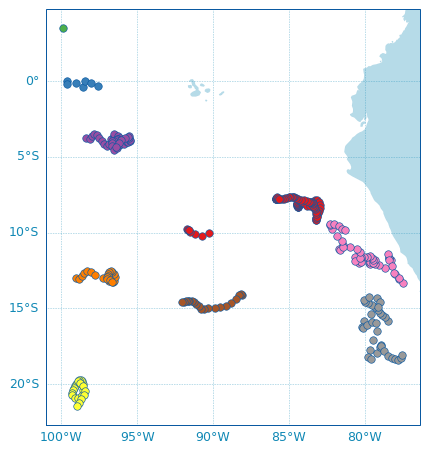

In [14]:
# But here, we use the index retrieved with the DataFetcher:
scatter_map(df, traj=False, set_global=False, legend=False);

## Make a map with one BGC parameter data mode

We can also make a scatter map with one BGC parameter data mode.

In [47]:
# Randomly select one BGC parameter to work with:
#a_param = bgc_params[np.random.randint(len(bgc_params))]
# select param below
a_param = 'DOXY'

In [48]:
# Get more verbose information about this parameter (usefull for plot titles):
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==a_param].iloc[0].to_dict()
param_info

{'altLabel': 'CHLA',
 'prefLabel': 'Chlorophyll-a concentration',
 'definition': 'Chlorophyll-a concentration (mg/m^3).',
 'deprecated': 'false',
 'id': 'http://vocab.nerc.ac.uk/collection/R03/current/CHLA/'}

In [49]:
# To make the scatter map, we need to have the data mode available in one DataFrame column
# so we need to add a new column with the DATA_MODE of the PARAMETER:
df["variables"] = df["parameters"].apply(lambda x: x.split())
df["%s_DM" % a_param] = df.apply(lambda x: x['parameter_data_mode'][x['variables'].index(a_param)] if a_param in x['variables'] else '', axis=1)

In [50]:
np.unique(df["%s_DM" % a_param])

array(['', 'A'], dtype=object)

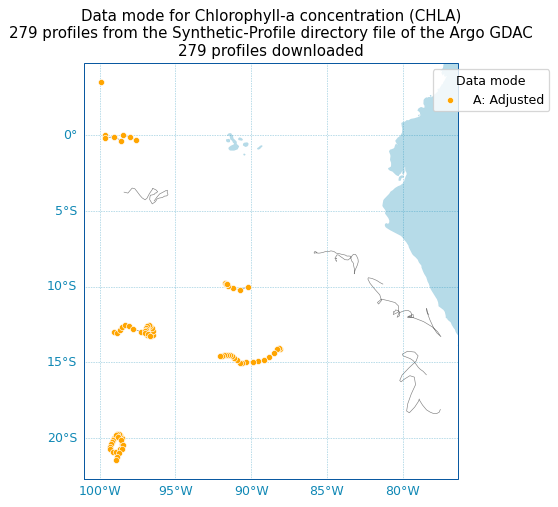

In [51]:
# Finally plot the map:
fig, ax = scatter_map(df,
                        hue="%s_DM" % a_param,
                        cmap="data_mode",
                        markersize=24,
                        markeredgecolor='w',
                        traj_color='gray',
                        legend_title='Data mode')
ax.set_title("Data mode for %s (%s)\n%i profiles from the %s\n%i profiles downloaded" % (param_info['prefLabel'], a_param, 
                                                                           idx.N_MATCH, idx.convention_title, df.shape[0]));

**Rq**: If some points have no data mode in the above map, it simply means that these profiles have not the request parameters

## Plot 

### Utilities

We will be using the argopy scatter_plot method that has the following signature:

```
scatter_plot(
    ds: xarray.core.dataset.Dataset,
    this_param,
    this_x='TIME',
    this_y='PRES',
    figsize=(18, 6),
    cmap=None,
    vmin=None,
    vmax=None,
    s=4,
)
```

In [52]:
# Try to define readible color bounds for each BGC variables 
# (this is probably NOT appropriate for all regions and periods !)
c_bounds = {'BBP700': (20e-5, 70e-5),
            'CDOM': (0.4, 0.8),
            'CHLA': (0, 1),
            'DOWNWELLING_PAR': (0, 10),
            'DOWN_IRRADIANCE380': (0, .1),
            'DOWN_IRRADIANCE412': (0, .1),
            'DOWN_IRRADIANCE490': (0, .1),
            'DOXY': (0,300),
            'NITRATE': (-2, 40),
            'PH_IN_SITU_TOTAL': (7, 8.5),
           }

In [53]:
# We''l make use of the argopy color scheme:
ArgoColors('qc')

### Plot some data QC

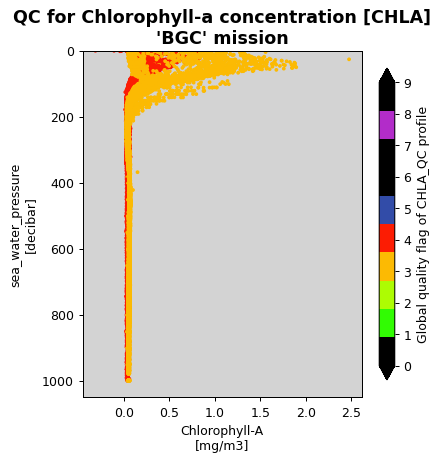

In [54]:
fig, ax = scatter_plot(ds, a_param + '_QC', this_x = a_param, 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5))
ax.set_title("QC for %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param, f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

(0.0, 1.0)

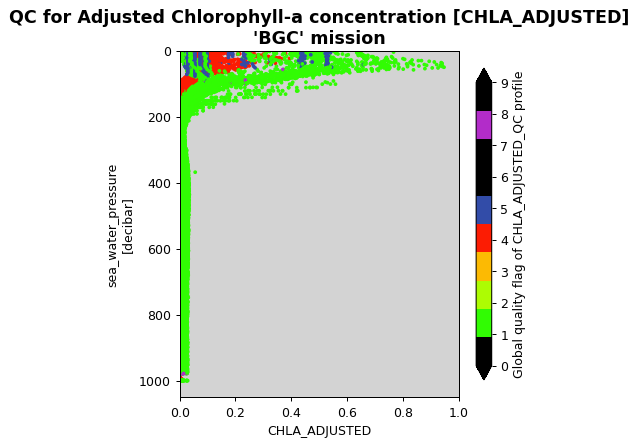

In [58]:
fig, ax = scatter_plot(ds, a_param + '_ADJUSTED_QC', this_x = a_param + '_ADJUSTED', 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5))
ax.set_title("QC for Adjusted %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param + '_ADJUSTED', f.mission), 
             fontdict={'weight': 'bold', 'size': 14});
ax.set_xlim([0, 1])

### Plot some variable against another

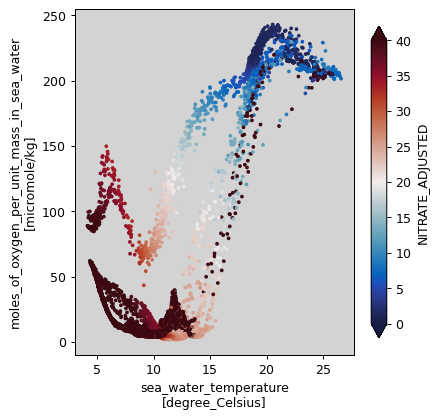

In [59]:
fig, ax = scatter_plot(ds, 'NITRATE_ADJUSTED', this_x = 'TEMP_ADJUSTED', this_y = 'DOXY_ADJUSTED', figsize=(5,5),cmap="cmo.balance",vmin=0,vmax=40)

### Plot time series

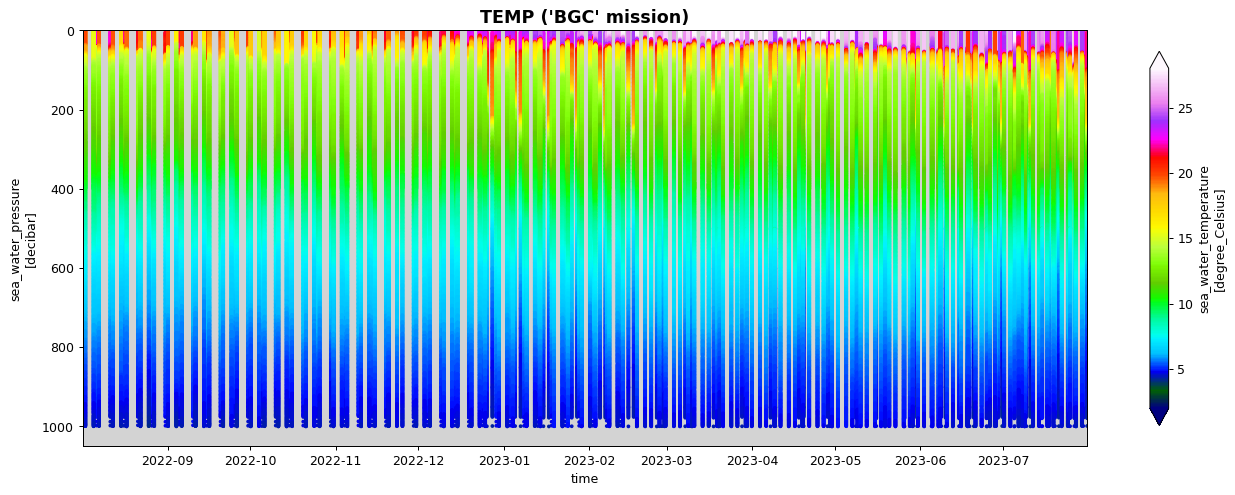

In [66]:
fig, ax = scatter_plot(ds, 'TEMP_ADJUSTED', vmin=2, vmax=28)
ax.set_title("%s ('%s' mission)" % ('TEMP', f.mission), fontdict={'weight': 'bold', 'size': 14});

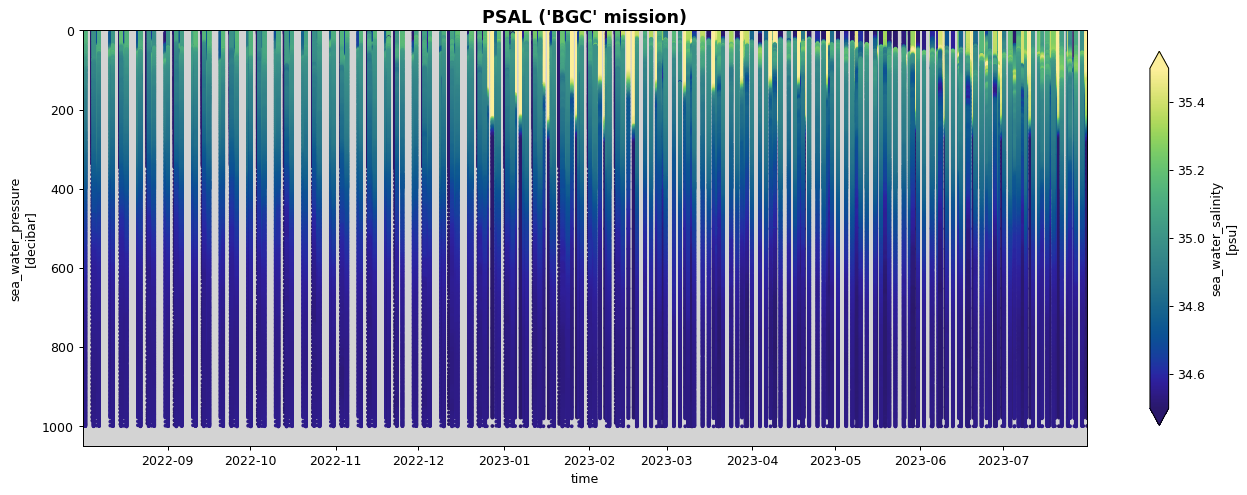

In [61]:
fig, ax = scatter_plot(ds, 'PSAL', cmap="cmo.haline", vmin=34.5, vmax=35)
ax.set_title("%s ('%s' mission)" % ('PSAL', f.mission), fontdict={'weight': 'bold', 'size': 14});

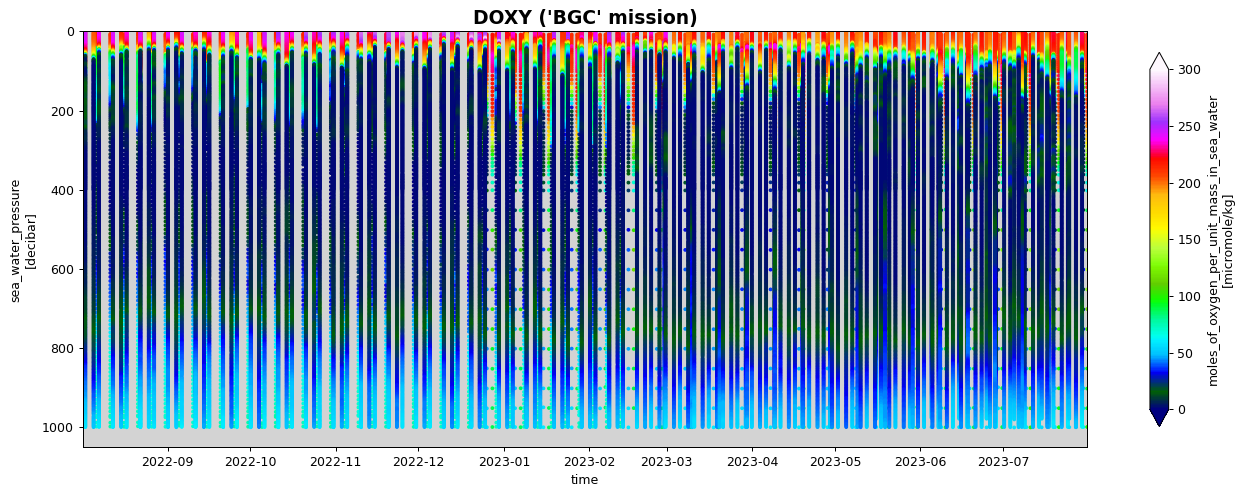

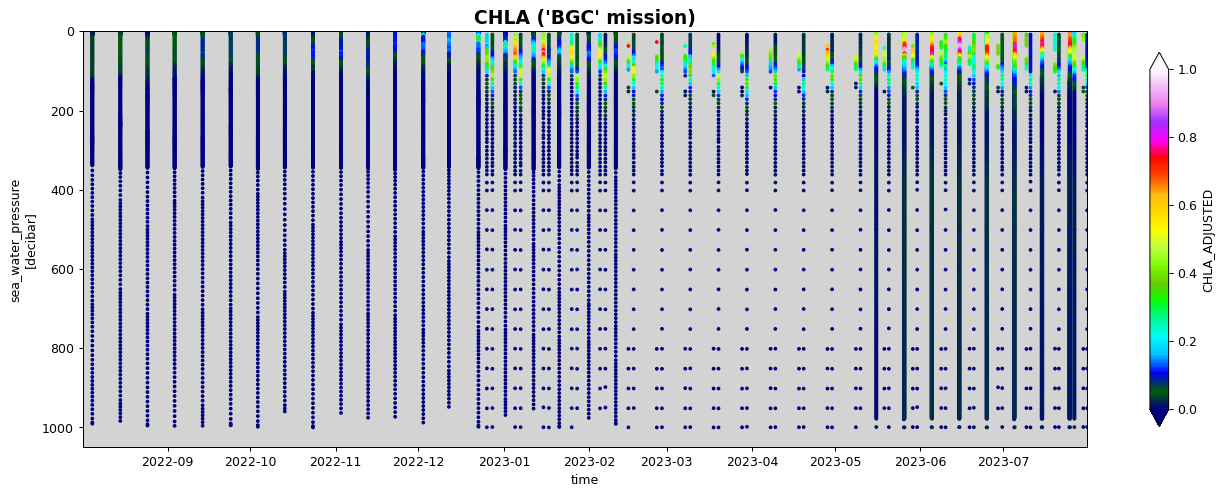

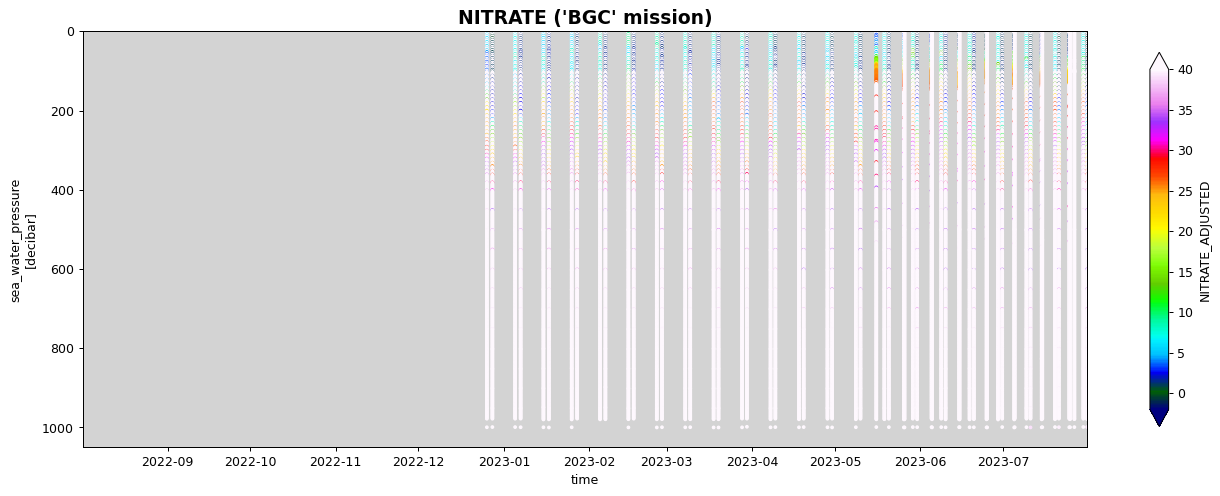

In [70]:
# Plot all BGC params
for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)    
    fig, ax = scatter_plot(ds, param+'_ADJUSTED', vmin=vmin, vmax=vmax)
    ax.set_title("%s ('%s' mission)" % (param, f.mission), fontdict={'weight': 'bold', 'size': 15});

In [71]:
ds

<xarray.Dataset>
Dimensions:                 (N_POINTS: 283166)
Coordinates:
    LATITUDE                (N_POINTS) float64 -14.11 -14.11 ... -9.832 -9.832
    LONGITUDE               (N_POINTS) float64 -88.07 -88.07 ... -81.31 -81.31
    TIME                    (N_POINTS) datetime64[ns] 2022-08-04T17:37:00 ......
  * N_POINTS                (N_POINTS) int64 0 1 2 3 4 ... 2488 2489 2490 2491
Data variables: (12/42)
    CHLA                    (N_POINTS) float32 0.073 0.0584 0.073 ... nan nan
    CHLA_ADJUSTED           (N_POINTS) float32 0.0146 0.0073 0.0146 ... nan nan
    CHLA_ADJUSTED_ERROR     (N_POINTS) float32 1e+05 1e+05 1e+05 ... nan nan nan
    CHLA_ADJUSTED_QC        (N_POINTS) int64 4 4 4 0 4 4 4 4 ... 0 0 0 0 0 0 0 0
    CHLA_DATA_MODE          (N_POINTS) <U1 '' '' '' '' '' '' ... '' '' '' '' ''
    CHLA_QC                 (N_POINTS) int64 4 4 4 0 4 4 4 4 ... 0 0 0 0 0 0 0 0
    ...                      ...
    TEMP_ADJUSTED           (N_POINTS) float32 nan nan nan ... 4.49 4.474 4.471
    TEMP_ADJUSTED_ERROR     (N_POINTS) float32 nan nan nan nan ... nan nan nan
    TEMP_ADJUSTED_QC        (N_POINTS) int64 0 0 0 0 0 0 0 0 ... 8 1 8 1 8 1 8 1
    TEMP_DATA_MODE          (N_POINTS) <U1 'A' 'A' 'A' 'A' 'A' ... '' '' '' ''
    TEMP_QC                 (N_POINTS) int64 3 3 3 3 3 3 3 3 ... 8 1 8 1 8 1 8 1
    TIME_QC                 (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes: (7)